## Tile Coding

---
<img src="Tiling.png" alt="drawing" width="800">
Tile coding is a form of coarse coding for multi-dimensional continuous spaces that is flexible and computationally efficient. It may be the most practical feature representation for modern sequential digital computers.


In tile coding the receptive fields of the features are grouped into partitions of the state space. Each such partition is called a tiling, and each element of the partition is called a tile.

---
## Tiling Offset

---
Tilings in all cases are offset from each other by a fraction of a tile width in each dimension. If `w` denotes the tile width and `n` the number of tilings, then `w` is a fundamental `w/n` unit.

In particular, for a continuous space of dimension `k`, a good choice is to use the first odd integers `(1,3,5,7,...,2k-1)`, with `n (the number of tilings)` set to an integer power of 2 greater than or equal to `4k`. (example: `<k = 2, n = 2^3 >= 4k>`)

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

For a 2 dimensional space with features `x`, `y`, and `number of tilings = n`, 
then 
> `for each tiling`:
>>   `bins` * `bins`

In [2]:
def create_tiling(feat_range, bins, offset):
    """
    Create 1 tiling spec of 1 dimension(feature)
    feat_range: feature range; example: [-1, 1]
    bins: number of bins for that feature; example: 10
    offset: offset for that feature; example: 0.2
    """
    
    return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset

In [3]:
feat_range = [0, 1.0]
bins = 10
offset = 0.2

tiling_spec = create_tiling(feat_range, bins, offset)

tiling_spec

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

In [106]:
def create_tilings(feature_ranges, number_tilings, bins, offsets):
    """
    feature_ranges: range of each feature; example: x: [-1, 1], y: [2, 5] -> [[-1, 1], [2, 5]]
    number_tilings: number of tilings; example: 3 tilings
    bins: bin size for each tiling and dimension; example: [[10, 10], [10, 10], [10, 10]]: 3 tilings * [x_bin, y_bin]
    offsets: offset for each tiling and dimension; example: [[0, 0], [0.2, 1], [0.4, 1.5]]: 3 tilings * [x_offset, y_offset]
    """
    tilings = []
    # for each tiling
    for tile_i in range(number_tilings):
        tiling_bin = bins[tile_i]
        tiling_offset = offsets[tile_i]
        
        tiling = []
        # for each feature dimension
        for feat_i in range(len(feature_ranges)):
            feat_range = feature_ranges[feat_i]
            # tiling for 1 feature
            feat_tiling = create_tiling(feat_range, tiling_bin[feat_i], tiling_offset[feat_i])
            tiling.append(feat_tiling)
        tilings.append(tiling)
    return np.array(tilings)

In [5]:
feature_ranges = [[-1, 1], [2, 5]]  # 2 features
number_tilings = 3
bins = [[10, 10], [10, 10], [10, 10]]  # each tiling has a 10*10 grid
offsets = [[0, 0], [0.2, 1], [0.4, 1.5]]

tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

print(tilings.shape)  # # of tilings X features X bins

(3, 2, 9)


In [6]:
tilings

array([[[-8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
         -2.00000000e-01,  0.00000000e+00,  2.00000000e-01,
          4.00000000e-01,  6.00000000e-01,  8.00000000e-01],
        [ 2.30000000e+00,  2.60000000e+00,  2.90000000e+00,
          3.20000000e+00,  3.50000000e+00,  3.80000000e+00,
          4.10000000e+00,  4.40000000e+00,  4.70000000e+00]],

       [[-6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
          5.55111512e-17,  2.00000000e-01,  4.00000000e-01,
          6.00000000e-01,  8.00000000e-01,  1.00000000e+00],
        [ 3.30000000e+00,  3.60000000e+00,  3.90000000e+00,
          4.20000000e+00,  4.50000000e+00,  4.80000000e+00,
          5.10000000e+00,  5.40000000e+00,  5.70000000e+00]],

       [[-4.00000000e-01, -2.00000000e-01,  1.11022302e-16,
          2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
          8.00000000e-01,  1.00000000e+00,  1.20000000e+00],
        [ 3.80000000e+00,  4.10000000e+00,  4.40000000e+00,
          4.70000000e+00,  5.00

In [7]:
def get_tile_coding(feature, tilings):
    """
    feature: sample feature with multiple dimensions that need to be encoded; example: [0.1, 2.5], [-0.3, 2.0]
    tilings: tilings with a few layers
    return: the encoding for the feature on each layer
    """
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = []
        for i in range(num_dims):
            feat_i = feature[i]
            tiling_i = tiling[i]  # tiling on that dimension
            coding_i = np.digitize(feat_i, tiling_i)
            feat_coding.append(coding_i)
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

In [8]:
feature = [0.1, 2.5]

coding = get_tile_coding(feature, tilings)
coding

array([[5, 1],
       [4, 0],
       [3, 0]])

### Q table & Tiling combine
---
For each tiling, there is a q table with size `<state_dim1 * state_dim2 * ... * action>`

In [191]:
class QValueFunction:
    
    def __init__(self, tilings, actions, lr):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.actions = actions
        self.lr = lr  # /self.num_tilings  # learning rate equally assigned to each tiling
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling) for tiling in self.tilings]  # [(10, 10), (10, 10), (10, 10)]
        self.q_tables = [np.zeros(shape=(state_size+(len(self.actions),))) for state_size in self.state_sizes]
        
    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
        action_idx = self.actions.index(action)
        
        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            # for each q table
            value += q_table[tuple(coding)+(action_idx,)]
        return value/self.num_tilings
    
    def update(self, state, action, target):
        state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
        action_idx = self.actions.index(action)
        
        for coding, q_table in zip(state_codings, self.q_tables):
            delta = target - q_table[tuple(coding)+(action_idx,)]
#             print("target {} delta {}".format(target, delta))
            q_table[tuple(coding)+(action_idx,)] += self.lr*(delta)
    
    # get the # of steps to reach the goal under current state value function
    def costToGo(self, state):
        costs = []
        for action in self.actions:
            costs.append(self.value(state, action))
        return -np.max(costs)

In [40]:
feature_ranges = [[-1, 1], [2, 5]]  # 2 features
number_tilings = 3
bins = [[10, 10], [10, 10], [10, 10]]  # each tiling has a 10*10 grid
offsets = [[0, 0], [0.2, 1], [0.4, 1.5]]

tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

q = QValueFunction(tilings, [-1, 0, 3], 0.1)

In [47]:
q.update([0.3, 2.4], -1, 2.1)
q.update([0.3, 2.4], -1, -10)
q.value([0.3, 4], -1)

0.0

## Apply on Mountain Car

In [169]:
class MountainCar:
    
    def __init__(self, n=1, exp_rate=0.1, gamma=1, debug=True):
        self.actions = [-1, 0, 1]  # reverse, 0 and forward throttle
        self.state = (-0.5, 0)  # position, velocity
        self.exp_rate = exp_rate
        self.gamma = 1
        self.end = False
        self.n = n  # step of learning
        self.debug = debug
        
    def reset(self):
        pos = np.random.uniform(-0.6, -0.4)
        self.end = False
        self.state = (pos, 0)
        
    def takeAction(self, action):
        pos, vel = self.state
        
        vel_new = vel + 0.001*action - 0.0025*np.cos(3*pos)
        vel_new = min(max(vel_new, VELOCITY_BOUND[0]), VELOCITY_BOUND[1])
        
        pos_new = pos + vel_new
        pos_new = min(max(pos_new, POSITION_BOUND[0]), POSITION_BOUND[1])
        
        if pos_new == POSITION_BOUND[0]:
            # reach leftmost, set speed to 0
            vel_new = 0
        self.state = (pos_new, vel_new)
        return self.state
    
    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value(self.state, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self):
        pos, _ = self.state
        if pos == POSITION_BOUND[1]:
            self.end = True
            return 0
        return -1
        
    def play(self, valueFunction, rounds=1):
        for rnd in range(1, rounds+1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            
            while True:
                if t < T:
#                     print("state {} take action {}".format(self.state, action))
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward
                    
                    states.append(state)
                    rewards.append(reward)
                    
                    if self.end:
                        if self.debug:
                            if rnd % 100 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state, len(states)))
                        T = t+1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau+1, min(tau+self.n+1, T+1)):
                        G += np.power(self.gamma, i-tau-1)*rewards[i]
                    if tau+self.n < T:
                        state = states[tau+self.n]
                        G += np.power(self.gamma, self.n)*valueFunction.value(state, actions[tau+self.n])
                    # update value function
                    state = states[tau]  # tau is the state to update
                    valueFunction.update(state, actions[tau], G)
                    
                if tau == T-1:
                    break
                
                t += 1

In [151]:
VELOCITY_BOUND = [-0.07, 0.07]
POSITION_BOUND = [-1.2, 0.5]
ACTIONS = [-1, 0, 1]

In [184]:
feature_ranges = [POSITION_BOUND, VELOCITY_BOUND]  # 2 features
number_tilings = 8
bins = [[16, 16] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], number_tilings), np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], number_tilings))]

tilings = create_tilings(feature_ranges=feature_ranges, number_tilings=number_tilings, bins=bins, offsets=offsets)

In [185]:
print("tiling shape: \n", tilings.shape)
print("offsets: \n", offsets)

tiling shape: 
 (8, 2, 15)
offsets: 
 [[-1.2, -0.07], [-0.9571428571428571, -0.05], [-0.7142857142857142, -0.030000000000000006], [-0.4714285714285714, -0.010000000000000009], [-0.22857142857142854, 0.009999999999999995], [0.014285714285714235, 0.03], [0.2571428571428571, 0.04999999999999999], [0.5, 0.07]]


In [186]:
valueFunc = QValueFunction(tilings, ACTIONS, 0.3)
mc = MountainCar()  # 1 step sarsa
mc.play(valueFunc, rounds=100)

Round 100: End at state (0.5, 0.009166098336318746) | number of states 1095


Text(0.5,0,'Cost to go')

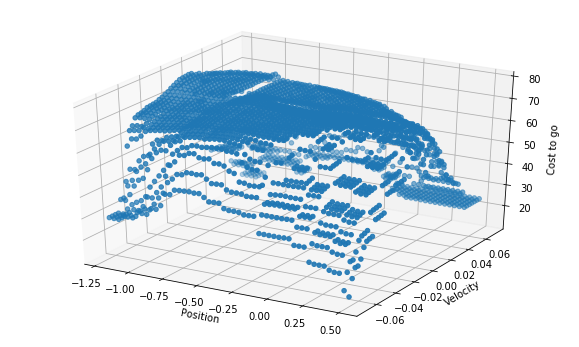

In [187]:
# step 100
grids = 50

positions = np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], grids)
vels = np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.costToGo([p, v]))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Position")
ax.set_ylabel("Velocity")
ax.set_zlabel("Cost to go")

## Apply on Random Walk

In [192]:
NUM_STATES = 1000
START = 500
END_0 = 0
END_1 = 1001

TRUE_VALUES = np.arange(-1001, 1003, 2) / 1001.0

In [ ]:
class RandomWalk:

    def __init__(self, step=1, lr=2e-5, exp_rate=0.2, gamma=1, debug=True):
        self.state = START
        self.actions = ["left", "right"]
        self.end = False
        self.n = step
        self.lr = lr
        self.gamma = gamma
        self.exp_rate = exp_rate
        self.debug = debug

    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value([self.state], a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])

        return action

    def takeAction(self, action):
        # choose steps from 1 to 100
        steps = np.random.choice(range(1, 101))
        if action == "left":
            state = self.state - steps
        else:
            state = self.state + steps
        # judge if end of game
        if state <= END_0 or state >= END_1:
            self.end = True
            if state <= END_0:
                state = END_0
            else:
                state = END_1

        self.state = state
        return state

    def giveReward(self):
        if self.state == END_0:
            return -1
        if self.state == END_1:
            return 1
        return 0

    def reset(self):
        self.state = START
        self.end = False

    def play(self, valueFunction, rounds=1e5):
        for rnd in range(1, rounds+1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)

            actions = [action]
            states = [self.state]
            rewards = [0]
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward

                    states.append(state)
                    rewards.append(reward)

                    if self.end:
                        if self.debug:
                            if rnd % 100 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state,
                                                                                               len(states)))
                        T = t + 1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau + 1, min(tau + self.n + 1, T + 1)):
                        G += np.power(self.gamma, i - tau - 1) * rewards[i]
                    if tau + self.n < T:
                        state = states[tau + self.n]
                        G += np.power(self.gamma, self.n) * valueFunction.value([state], actions[tau+self.n])
                    # update value function
                    state = states[tau]
                    action = actions[tau]
                    valueFunction.update([state], action, G)

                if tau == T - 1:
                    break

                t += 1

In [195]:
feature_ranges = [[0, 1000]]  # 1 features
number_tilings = 50
bins = [[10] for _ in range(number_tilings)]
offsets = [[i] for i in np.linspace(0, 1000, number_tilings)]

tilings = create_tilings(feature_ranges=feature_ranges, number_tilings=number_tilings, bins=bins, offsets=offsets)

In [ ]:
rw = RandomWalk()
valueFunc = QValueFunction(tilings, ["left", "right"], 0.01)

rw.play(valueFunction=valueFunc, rounds=1000)

In [197]:
for s in np.linspace(1, 901, 10):
    for a in ["left", "right"]:
        v = valueFunc.value([s], a)
        print("state {} acton {} -> value {}".format(s, a, v))

state 1.0, acton left -> value 0.0
state 1.0, acton right -> value -0.010000000000000004
state 101.0, acton left -> value 0.0
state 101.0, acton right -> value -0.009800000000000005
state 201.0, acton left -> value 0.0
state 201.0, acton right -> value -0.009000000000000005
state 301.0, acton left -> value 0.0
state 301.0, acton right -> value -0.008000000000000004
state 401.0, acton left -> value 0.0
state 401.0, acton right -> value -0.007000000000000003
state 501.0, acton left -> value 0.0
state 501.0, acton right -> value -0.006000000000000002
state 601.0, acton left -> value 0.0
state 601.0, acton right -> value -0.005000000000000001
state 701.0, acton left -> value 0.0
state 701.0, acton right -> value -0.004000000000000001
state 801.0, acton left -> value 0.0
state 801.0, acton right -> value -0.003
state 901.0, acton left -> value 0.0
state 901.0, acton right -> value -0.002
